In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import datetime

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [262]:
airlines_passengers = pd.read_csv("../1. Знакомство с временными рядами/Series/international-airline-passengers.csv")

Берем ряд international-airline-passengers, который из первого ДЗ показал наличие тренда и сезонности.
ap_original - оригинальный ряд
ap_stationary - стационарный ряд, после преобразования Бокса-Кокса, и дифференциирования (тренд и сезонность).

In [263]:
airlines_passengers.rename(columns = {'Count':'Original'}, inplace = True)
airlines_passengers.tail(20)

,Month,Original
124,1959-05,420
125,1959-06,472
126,1959-07,548
127,1959-08,559
128,1959-09,463
129,1959-10,407
130,1959-11,362
131,1959-12,405
132,1960-01,417
133,1960-02,391


In [367]:
series = np.array(airlines_passengers["Original"])

series, lam = boxcox(series) 
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]
ap_stationary = series


In [282]:
 # Dickey-Fuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %.3f, p-value: %.3f' % (dftest[0],dftest[1]))
    print('Critical Values:', end=" ")
    for key, value in dftest[4].items():
      print('%s: %.3f ' % (key, value), end='')
    print('\n')

In [283]:
test_stationarity(airlines_passengers["Original"])
test_stationarity(ap_stationary)


ADF Statistic: 0.815, p-value: 0.992
Critical Values: 1%: -3.482 5%: -2.884 10%: -2.579 

ADF Statistic: -4.394, p-value: 0.000
Critical Values: 1%: -3.487 5%: -2.886 10%: -2.580 



In [284]:

#exponential moving average
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

#double exponential moving average

def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

#triple exponential smoothing

def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

### Возьмем с 49 по 59 годы в качестве трейна, и последницй год, в качестве теста.


In [285]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [341]:
import warnings
warnings.filterwarnings('ignore')

series = airlines_passengers["Original"]
train, test = series[:126], series[126:132]

def mse(X):
    alpha = X
    result = exponential_moving_average(train, alpha, len(test))[0]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0], method="L-BFGS-B")

alpha_opt = opt.x
print(opt)

      fun: 5491.555555555555
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.09494697e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([0.85746422])


In [337]:
series = airlines_passengers["Original"]
train, test = series[:126], series[126:132]

def mse(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))[0]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

alpha_opt, beta_opt = opt.x
print(opt)

      fun: 6292.302416100613
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0084583 , 0.00336513])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 15
     njev: 22
   status: 0
  success: True
        x: array([0.49713538, 0.02069201])


In [338]:
series = airlines_passengers["Original"]
train, test = series[:126], series[126:132]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1329.8410532407413
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -41.3642281 , 32902.78955319,    -0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([1., 0., 1.])


<AxesSubplot:>

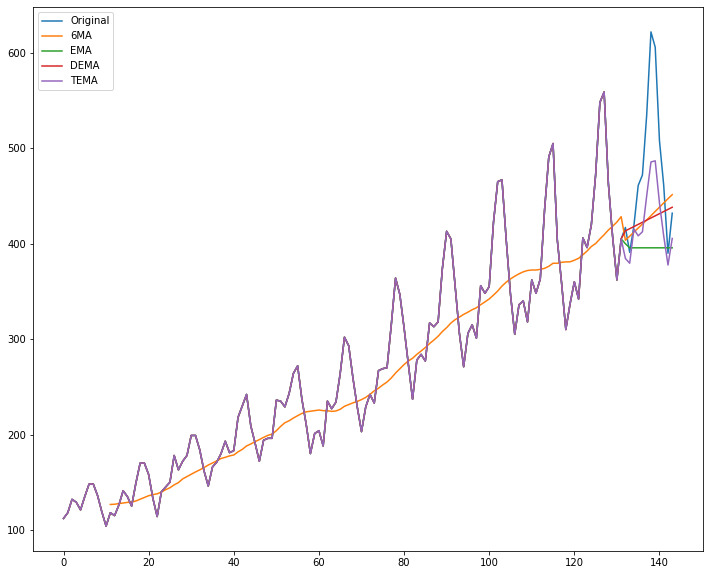

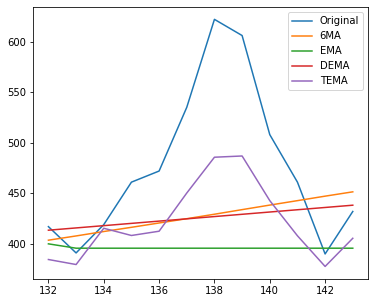

In [339]:
series = airlines_passengers["Original"][:-12]

#Moving average for original series
airlines_passengers["6MA"] = airlines_passengers['Original'].rolling(window=12).mean()
# Predict the next 12 values using the last calculated moving average value

airlines_passengers["6MA"].iloc[132:] = airlines_passengers["6MA"].iloc[120:].rolling(window=12, closed="left").mean().tail(12)


airlines_passengers["EMA"] = exponential_moving_average(series, 0.85746422, n_pred=12)[0]
airlines_passengers["DEMA"] = double_ema_with_preds(series, 0.49713538, 0.02069201, n_preds=12)[0]
airlines_passengers["TEMA"] = triple_exponential_smoothing(series, 12, 1, 0, 1, n_preds=12)

airlines_passengers[["Original", "6MA", "EMA", "DEMA", "TEMA"]].plot(figsize=(12, 10))
airlines_passengers[["Original", "6MA", "EMA", "DEMA", "TEMA"]].iloc[132:].plot(figsize=(6, 5))

### Проделаем тоже самое со стационарным рядом

In [351]:
import warnings
warnings.filterwarnings('ignore')

series = pd.Series(ap_stationary)
train, test = series[:113], series[113:119]

def mse(X):
    alpha = X
    result = exponential_moving_average(train, alpha, len(test))[0]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0], method="L-BFGS-B")

alpha_opt = opt.x
print(opt)

      fun: 0.002309426670349228
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.65332158e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.23794117])


In [353]:
series = pd.Series(ap_stationary)
train, test = series[:113], series[113:119]

def mse(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))[0]
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

alpha_opt, beta_opt = opt.x
print(opt)

      fun: 0.002154783113305189
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.66253730e-05, -8.87324069e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 129
      nit: 26
     njev: 43
   status: 0
  success: True
        x: array([0.05656433, 0.16354795])


In [354]:
series = pd.Series(ap_stationary)
train, test = series[:113], series[113:119]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.0030829743064321735
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.65447386e-06,  7.55007480e-03, -4.81949550e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 100
      nit: 16
     njev: 25
   status: 0
  success: True
        x: array([0.04821968, 0.        , 0.00101585])


<AxesSubplot:>

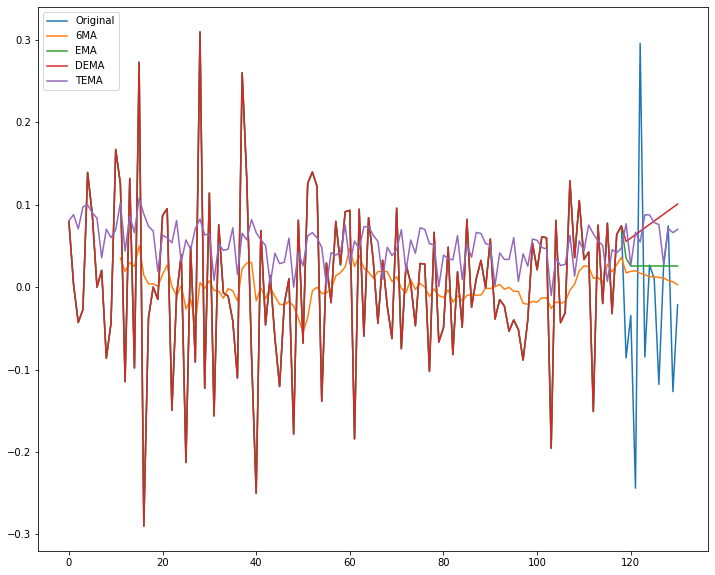

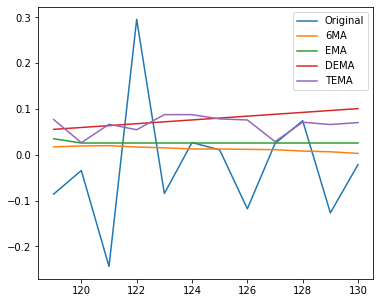

In [371]:
series = ap_stationary["Original"][:-12]

#Moving average for original series
ap_stationary["6MA"] = ap_stationary["Original"].rolling(window=12).mean()
# Predict the next 12 values using the last calculated moving average value

ap_stationary["6MA"].iloc[119:] = ap_stationary["6MA"].iloc[107:].rolling(window=12, closed="left").mean().tail(12)


ap_stationary["EMA"] = exponential_moving_average(series, 0.23794117, n_pred=12)[0]
ap_stationary["DEMA"] = double_ema_with_preds(series, 0.05656433, 0.16354795, n_preds=12)[0]
ap_stationary["TEMA"] = triple_exponential_smoothing(series, 12, 0.04821968, 0.        , 0.00101585, n_preds=12)

ap_stationary[["Original", "6MA", "EMA", "DEMA", "TEMA"]].plot(figsize=(12, 10))
ap_stationary[["Original", "6MA", "EMA", "DEMA", "TEMA"]].iloc[119:].plot(figsize=(6, 5))

In [374]:
for column in airlines_passengers[["EMA", "DEMA", "TEMA", "6MA"]].iloc[132:]:
    print("Smoothing: %s, RMSE: %.3f" % (airlines_passengers[column].iloc[132:].name, mean_squared_error(airlines_passengers.iloc[132:]["Original"], airlines_passengers[column].iloc[132:], squared=False)))


Smoothing: EMA, RMSE: 109.558
Smoothing: DEMA, RMSE: 88.948
Smoothing: TEMA, RMSE: 67.955
Smoothing: 6MA, RMSE: 87.982


In [373]:
for column in ap_stationary[["EMA", "DEMA", "TEMA", "6MA"]].iloc[119:]:
    print("Smoothing Stationary: %s, RMSE: %.3f" % (ap_stationary[column].iloc[119:].name, mean_squared_error(ap_stationary.iloc[119:]["Original"], ap_stationary[column].iloc[119:], squared=False)))


Smoothing Stationary: EMA, RMSE: 0.137
Smoothing Stationary: DEMA, RMSE: 0.163
Smoothing Stationary: TEMA, RMSE: 0.160
Smoothing Stationary: 6MA, RMSE: 0.133


Вывод, что для нестационарного ряда потребовалось сглаживание TEMA, чтобы убрать и тренд, и сезонность. Это улучшило результаты.
А вот для уже стационарно ряда, где убрали их вручную, сглаживание, только ухужшило результат. Там достаточно и обычного среднего с окном в 6 месяцев, например.

### Попробую воспользоваться встроенными статмоделями

In [375]:
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

<AxesSubplot:>

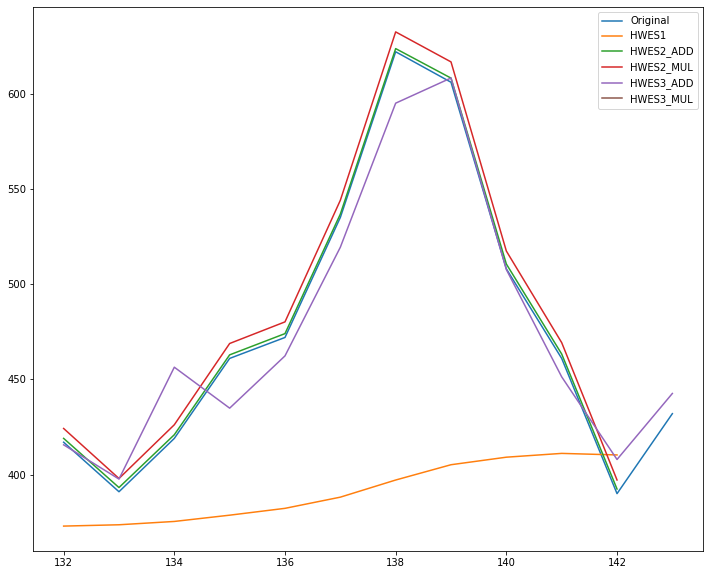

In [416]:
airlines_passengers["HWES1"] = SimpleExpSmoothing(airlines_passengers["Original"]).fit(smoothing_level=1/(2*13),optimized=False,use_brute=True).fittedvalues.shift(-1)
airlines_passengers["HWES2_ADD"] = ExponentialSmoothing(airlines_passengers["Original"],trend="add").fit().fittedvalues.shift(-1)
airlines_passengers["HWES2_MUL"] = ExponentialSmoothing(airlines_passengers["Original"],trend="mul").fit().fittedvalues.shift(-1)

airlines_passengers["HWES3_ADD"] = ExponentialSmoothing(airlines_passengers["Original"],trend="add",seasonal="add",seasonal_periods=12).fit().fittedvalues
airlines_passengers["HWES3_MUL"] = ExponentialSmoothing(airlines_passengers["Original"],trend="mul",seasonal="mul",seasonal_periods=12).fit().fittedvalues

airlines_passengers[["Original","HWES1", "HWES2_ADD", "HWES2_MUL", "HWES3_ADD", "HWES3_MUL"]].iloc[132:].plot(figsize=(12, 10))

#### Вопрос: Тройное сглаживание с методом мультипликации дало NaNs почему-то

In [405]:
train_airline = airlines_passengers[:132]
test_airline = airlines_passengers[132:]

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

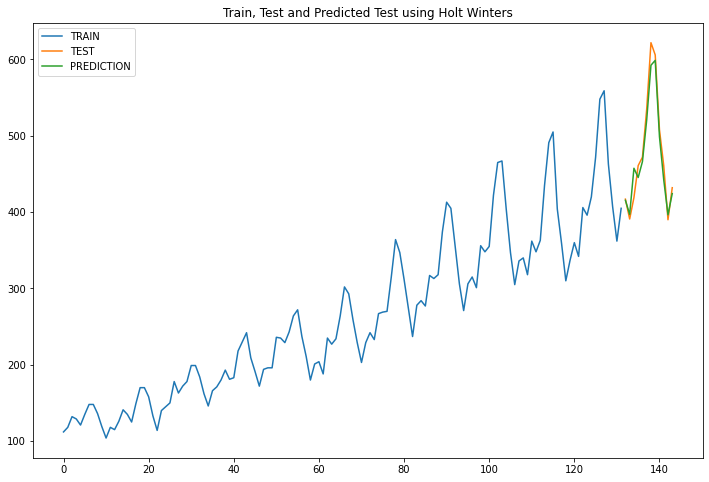

In [414]:
fitted_model = ExponentialSmoothing(train_airline["Original"],trend="add",seasonal="add",seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(12)

train_airline["Original"].plot(legend=True,label="TRAIN")
test_airline["Original"].plot(legend=True,label="TEST",figsize=(12,8))
test_predictions.plot(legend=True,label="PREDICTION")
plt.title("Train, Test and Predicted Test using Holt Winters")

In [413]:
print("RMSE: %.3f" % mean_squared_error(test_airline["Original"], test_predictions, squared=False))

RMSE: 16.980


In [417]:
### Встроенный функционал из библиотеки дал лучше результат, видимо я напутал с альфа, бета, гаммой